## Setting up the environment


In [1]:
import gymnasium as gym
import text_flappy_bird_gym

if __name__ == "__main__":
    env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

## Implement first-visit on-policy MC Control


In [7]:
import numpy as np
import scipy
from matplotlib import pyplot as plt


class MC_Control:
    def __init__(self, space_size, action_size, gamma=1):
        # -------
        self.gamma = gamma
        self.space_size = space_size
        self.action_size = action_size
        self.Qvalues = np.zeros((*self.space_size, self.action_size))

        # ------- serve solo a MC
        self.returns = [
            [[[] for _ in range(2)] for _ in range(self.space_size[0])]
            for _ in range(self.space_size[1])
        ]

    def discount_cumsum(self, x, discount):
        return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()

        if ran < eps:
            prob_actions = np.ones(self.action_size) / self.action_size

        else:
            best_value = np.max(self.Qvalues[(*s,)])

            best_actions = self.Qvalues[(*s,)] == best_value

            prob_actions = best_actions / np.sum(best_actions)

        a = np.random.choice(self.action_size, p=prob_actions)
        return a

    def greedy_policy(self):
        a = np.argmax(self.Qvalues, axis=2)
        return a

    # -------- serve solo a MC
    def single_episode_update(self, traj_states, traj_rew, traj_act):
        """
        Uses a single trajectory to update the Qvalues, using first-visit MC.
        """
        # keep track of visited pair (state, action)
        visited_pairs = []
        remaining_pairs = [(traj_states[t], traj_act[t]) for t in range(len(traj_act))]

        # calculates the returns for each step: DISCOUNTed CUMulative SUM.
        ret = self.discount_cumsum(traj_rew, self.gamma)

        # given teh current episode, take the last pair (St, At) and go backward
        for t_step, s in reversed(list(enumerate(traj_states))):
            # get the action taken after being in state s
            action = traj_act[t_step]

            # build the pair (St, At) = ((x,y), At)
            pair = (s, action)

            remaining_pairs.pop()

            if pair in remaining_pairs:
                # print("pair: ", pair)
                s = pair[0]
                action = pair[1]
                # print(s)

                self.returns[s[0]][s[1]][action].append(ret[t_step])
            else:
                self.returns[s[0]][s[1]][action].append(ret[t_step])
                visited_pairs.append((s, action))

        for pair in visited_pairs:
            s = pair[0]
            action = pair[1]
            self.Qvalues[s[0]][s[1]][action] = np.mean(self.returns[s[0]][s[1]][action])

    def train(self, n_episodes=10000, tstar=None, epsilon_0=0.2, k=0.0):
        # new attributes
        self.performance_traj = np.zeros(n_episodes)
        self.epsilon_0 = epsilon_0
        self.k = k
        self.n_episodes = n_episodes

        count = 0
        if tstar is None:
            tstar = 2.5 * n_episodes
        epsilon = epsilon_0
        Actions = [i for i in range(self.action_size)]

        for i in range(n_episodes):
            traj_states = []
            traj_rew = []
            traj_act = []
            done = False

            s, info = env.reset()
            a = self.get_action_epsilon_greedy(s=s, eps=epsilon)
            act = Actions[a]

            while not done:
                count += 1

                new_s, r, done, _, info = env.step(act)
                traj_states.append(s)
                traj_act.append(a)
                traj_rew.append(r)

                # Keeps track of performance for each episode
                self.performance_traj[i] += r

                # Choose new action index
                new_a = self.get_action_epsilon_greedy(new_s, epsilon)

                # (Corresponding action to index)
                act = Actions[new_a]
                a = new_a
                s = new_s

                if count > tstar:
                    # UPDATE OF EPSILON
                    epsilon = epsilon_0 / (1.0 + k * (count - tstar) ** 1.05)

            # MC step at the end of the episode (averaging)
            self.single_episode_update(traj_states, traj_rew, traj_act)

    def plot_traj(self, cumulative=True, local=False, save=False):
        # CAMBIARE IL TITOLO
        title = "MC"

        plot_indexes = np.arange(0, self.n_episodes + 1, 20, dtype=int)
        plot_indexes[-1] = plot_indexes[-1] - 1

        plt.plot(plot_indexes, self.performance_traj[plot_indexes])

        if cumulative:
            cumulative_mean = np.cumsum(self.performance_traj) / np.arange(
                1, len(self.performance_traj) + 1
            )
            plt.plot(
                plot_indexes, cumulative_mean[plot_indexes], label="Cumulative mean"
            )
        if local:
            window_size = 100
            local_mean_SARSA = np.convolve(
                self.performance_traj, np.ones(window_size) / window_size, mode="valid"
            )
            plt.plot(
                plot_indexes[plot_indexes < local_mean_SARSA.shape[0]],
                local_mean_SARSA[
                    plot_indexes[plot_indexes < local_mean_SARSA.shape[0]]
                ],
                label=" Local Mean",
            )
        plt.xlabel("Episode")
        plt.ylabel("Episode reward")
        plt.legend()
        plt.suptitle(f"{title} control cumulative rewards")
        plt.title(f"Epsilon0 = {self.epsilon_0}, k = {self.k}")

        # SISTEMARE SALVATAGGIO IN CARTELLA GIUSTA
        if save:
            name = "Plots/MC_plots/MC_k_epsilon" + str(self.k) + ".png"
            plt.savefig(name)

In [8]:
observation_space = (env.observation_space[0].n, env.observation_space[1].n)

In [20]:
n_episodes = 10000

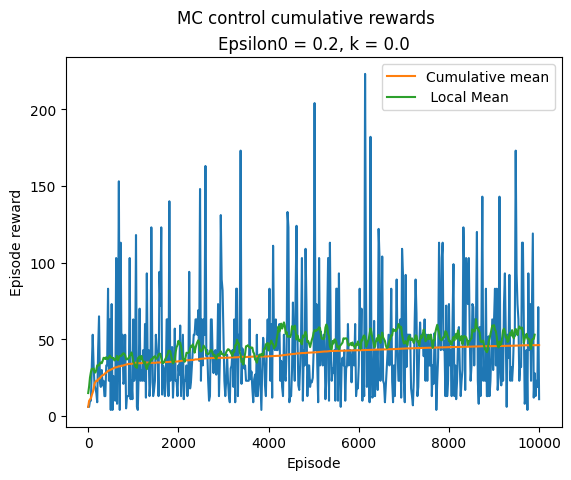

In [21]:
MC = MC_Control(space_size=observation_space, action_size=2, gamma=1)
MC.train(n_episodes=n_episodes, epsilon_0=0.2, k=0.0)
MC.plot_traj(cumulative=True, local=True, save=True)

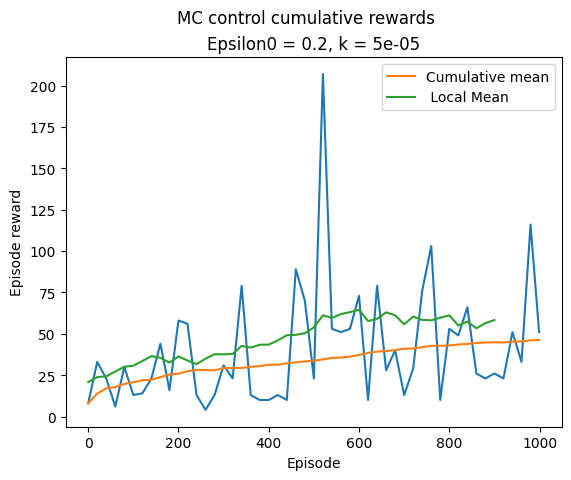

In [13]:
MC = MC_Control(space_size=observation_space, action_size=2, gamma=1)
MC.train(n_episodes=n_episodes, epsilon_0=0.2, k=0.00005)
MC.plot_traj(cumulative=True, local=True, save=True)

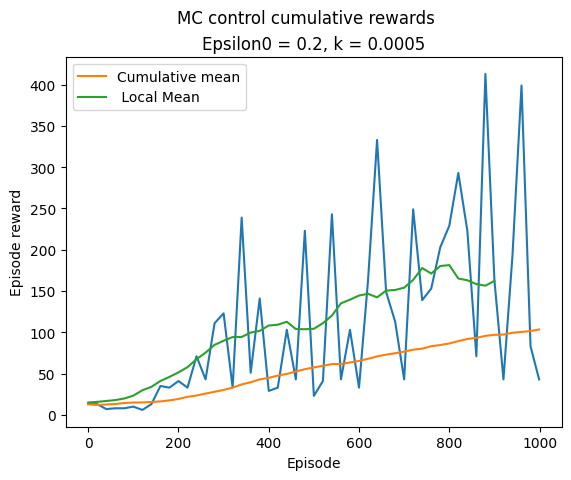

In [14]:
MC = MC_Control(space_size=observation_space, action_size=2, gamma=1)
MC.train(n_episodes=n_episodes, epsilon_0=0.2, k=0.0005)
MC.plot_traj(cumulative=True, local=True, save=True)

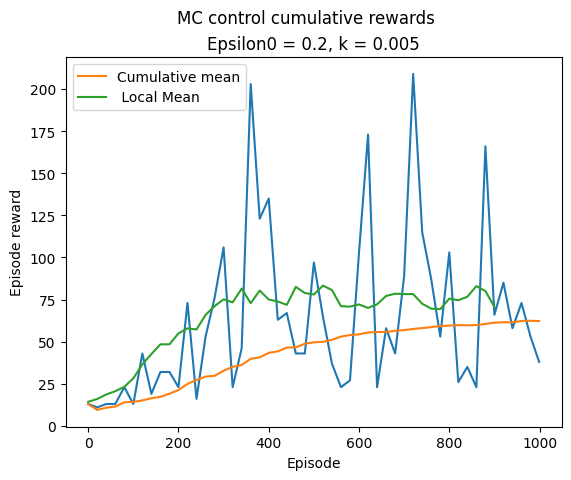

In [15]:
MC = MC_Control(space_size=observation_space, action_size=2, gamma=1)
MC.train(n_episodes=n_episodes, epsilon_0=0.2, k=0.005)
MC.plot_traj(cumulative=True, local=True, save=True)

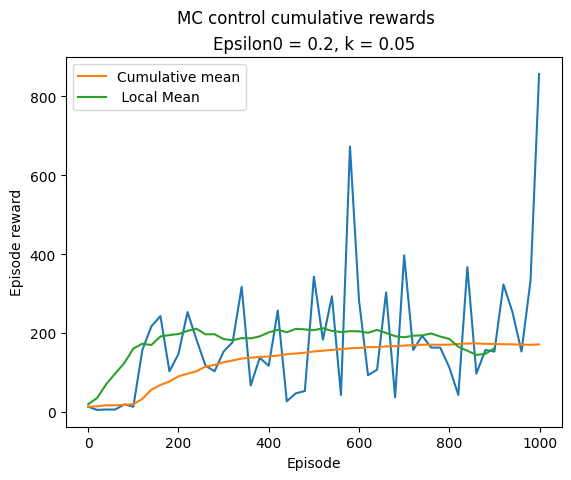

In [16]:
MC = MC_Control(space_size=observation_space, action_size=2, gamma=1)
MC.train(n_episodes=n_episodes, epsilon_0=0.2, k=0.05)
MC.plot_traj(cumulative=True, local=True, save=True)

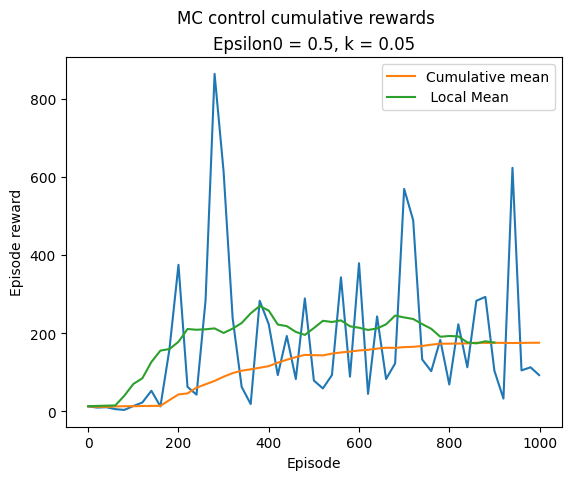

In [19]:
MC = MC_Control(space_size=observation_space, action_size=2, gamma=1)
MC.train(n_episodes=n_episodes, epsilon_0=0.5, k=0.05)
MC.plot_traj(cumulative=True, local=True, save=True)